In [1]:
import logging
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import cv2
import torch
import torch.nn.functional as F
import math
import pandas as pd
import PIL.Image as Image
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn.functional as F
import segmentation_models_pytorch as smp
from collections import OrderedDict
import torch
import torch.nn as nn
import PIL.Image as Image
from torchvision.transforms import ToTensor, ToPILImage
import torch.nn.functional as F
import pickle
from tqdm import tqdm_notebook as tqdm
import torchvision
import time
from collections import defaultdict
from torch.nn import CTCLoss
from Levenshtein import distance
import random
from torch.utils import data
from torch.utils.data import DataLoader

In [2]:
class ImageDataset(data.Dataset):
    """
    Dataset class for handwritten lines.

    Parameters
    ----------
    pickle_file : str
        Path to a dataset pickle file.
    meta : bool
        If True, meta data about files is provided.
    num_imgs : int, optional (default=-1)
        Choose only `num_imgs` imgs for processing. If set to -1, uses all available images.

    """

    def __init__(self, pickle_file, meta=False, num_imgs=-1):
        with open(pickle_file, 'rb') as f:
            dataset = pickle.load(f)
        self.reference_dataset = dataset
        self.num_imgs = num_imgs
        if (self.num_imgs > 0) and (self.num_imgs < len(self.reference_dataset)):
            inds = np.random.choice(np.arange(len(self.reference_dataset)),
                                    self.num_imgs, replace=False)
            self.reference_dataset = [self.reference_dataset[i] for i in inds]
        self.meta = meta

    def __getitem__(self, idx):
        data = self.reference_dataset[idx]
        #img = cv2.imread(data['img_path'], cv2.IMREAD_UNCHANGED) / 255.
        img = cv2.resize(cv2.imread(data['img_path'], 0), (444,64)) / 255.
        img = torch.from_numpy(img).unsqueeze(0).float()
        text = data['description']
        width = data['width']
        height = data['height']

        if self.meta:
            return img, text, data, width, height
        else:
            return img, text

    def __len__(self):
        return len(self.reference_dataset)
    
class strLabelConverter(object):
    """Convert between str and label.
    NOTE:
        Insert `blank` to the alphabet for CTC.
    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index
        #self.alphabet = alphabet

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1
    
    def encode(self, text):
        """Support batch or single str.
        Args:
            text (str or list of str): texts to convert.
        Returns:
            torch.LongTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.LongTensor [n]: length of each text.
        """

        length = []
        result = []
        for item in text:            
#             item = item.decode('utf-8','strict')
            length.append(len(item))
            r = []
            for char in item:
                index = self.dict[char]
                # result.append(index)
                r.append(index)
            result.append(r)
        
        max_len = 0
        for r in result:
            if len(r) > max_len:
                max_len = len(r)
        
        result_temp = []
        for r in result:
            for i in range(max_len - len(r)):
                r.append(0)
            result_temp.append(r)

        text = result_temp
        return (torch.LongTensor(text), torch.LongTensor(length))


    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.
        Args:
            torch.LongTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.LongTensor [n]: length of each text.
        Raises:
            AssertionError: when the texts and its length does not match.
        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.LongTensor([l]), raw=raw))
                index += l
            return texts

In [3]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output
    
class CRNN(nn.Module):

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        cnn = nn.Sequential()
        one_d_cnn = nn.Sequential()

        def ConvBlock(in_c, out_c, k_s, padding, stride, dilation = 1, batchNorm=False, dropout = None, pooling = None, number = 0):
            
            cnn.add_module('conv{0}'.format(number),
                           nn.Conv2d(in_c, out_c, k_s, stride, padding, dilation))
            if batchNorm:
                cnn.add_module('batchnorm{0}'.format(number), nn.BatchNorm2d(out_c))
            cnn.add_module('relu{0}'.format(number), nn.ReLU(True))
            if dropout is not None:
                cnn.add_module('dropout{0}'.format(number), nn.Dropout2d(p=dropout))
            if pooling is not None:
                cnn.add_module('pooling{0}'.format(number), nn.MaxPool2d(*pooling))

        ConvBlock(in_c=nc, out_c=16, k_s=3, padding=1, stride=1, 
                  dilation = 1, batchNorm=True, dropout = None, pooling = [2,2], number=0)
        ConvBlock(in_c=16, out_c=32, k_s=3, padding=1, stride=1, 
                  dilation = 1, batchNorm=True, dropout = 0.2, pooling = [2,2], number=1)
        ConvBlock(in_c=32, out_c=64, k_s=3, padding=1, stride=1, 
                  dilation = 1, batchNorm=True, dropout = 0.2, pooling = None, number=2)
        ConvBlock(in_c=64, out_c=128, k_s=3, padding=1, stride=1, 
                  dilation = 1, batchNorm=True, dropout = None, pooling = [(2, 2), (2, 1), (0, 1)], number=3)
        ConvBlock(in_c=128, out_c=128, k_s=3, padding=1, stride=1, 
                  dilation = 1, batchNorm=True, dropout = 0.1, pooling = None, number=4)
        ConvBlock(in_c=128, out_c=128, k_s=3, padding=1, stride=1, 
                  dilation = 1, batchNorm=True, dropout = 0.1, pooling = [(2, 2), (2, 1), (0, 1)], number=5)
        ConvBlock(in_c=128, out_c=256, k_s=3, padding=0, stride=(1,2), 
                  dilation = 1, batchNorm=True, dropout = None, pooling = None, number=6)
        ConvBlock(in_c=256, out_c=512, k_s=2, padding=0, stride=(2,1), 
                  dilation = 1, batchNorm=True, dropout = None, pooling = None, number=7)
        
        one_d_cnn.add_module('conv1d_1',
                           nn.Conv1d(512, 256, 5, 1, 1))
        one_d_cnn.add_module('batchnorm_1', nn.BatchNorm1d(256))
        one_d_cnn.add_module('relu_1', nn.ReLU(True))
        one_d_cnn.add_module('conv1d_2',
                           nn.Conv1d(256, 256, 3, 1, 1, 2))
        one_d_cnn.add_module('batchnorm_2', nn.BatchNorm1d(256))
        one_d_cnn.add_module('relu_2', nn.ReLU(True))
        one_d_cnn.add_module('conv1d_3',
                           nn.Conv1d(256, 128, 3, 1, 1, 3))
        one_d_cnn.add_module('batchnorm_3', nn.BatchNorm1d(128))
        one_d_cnn.add_module('relu_3', nn.ReLU(True))
        one_d_cnn.add_module('conv1d_4',
                           nn.Conv1d(128, 128, 3, 1, 1))
        one_d_cnn.add_module('batchnorm_4', nn.BatchNorm1d(128))
        one_d_cnn.add_module('relu_4', nn.ReLU(True))
        one_d_cnn.add_module('conv1d_5',
                           nn.Conv1d(128, 80, 1, 1, 0))
        

        self.cnn = cnn
        self.one_d_cnn = one_d_cnn

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        conv = self.one_d_cnn(conv.squeeze(2))
        #b, c, h, w = conv.size()
        #assert h == 1, "the height of conv must be 1"
        #conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        #output = self.rnn(conv)
        
        # add log_softmax to converge output
        output = F.log_softmax(conv, dim=2)

        return output


    def backward_hook(self, module, grad_input, grad_output):
        for g in grad_input:
            g[g != g] = 0   # replace all nan/inf in gradients to zero

In [4]:
def train_on_batch_rec(images, gt_text, model_crnn, ocr_loss, optimizer, device, batch_size, converter):

    model_crnn.train()
    
    pred_text = model_crnn(images.to(device))
    
    preds_size = torch.LongTensor([pred_text.size(0)] * batch_size)
    
    t_text, l_text = converter.encode(list(gt_text))
    
    loss = ocr_loss(pred_text, t_text, preds_size, l_text)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, decode_text = pred_text.max(2)
    decode_text = decode_text.transpose(1, 0).contiguous().view(-1)
    decode_text = converter.decode(decode_text.data, preds_size, raw=False)
    
    char_correct = 0
    total_char = 0
    for pred, gt in zip(decode_text, gt_text):
        for i, pred_char in enumerate(pred):
            if i<len(gt):
                if pred_char == gt[i]:
                    char_correct += 1
        total_char += len(gt)
            
    acc_char = (char_correct)/float(total_char)
    
    total_str = 0
    n_correct = 0
    cer = 0
    for pred, target in zip(decode_text, gt_text):
        if pred == target:
            n_correct += 1
        else:
            cer += distance(pred, target)/len(target)
        total_str+=1
            
    acc_str = (n_correct)/total_str
    cer = cer/total_str
    
    return (loss.item(), acc_char, acc_str, cer)

def val_on_batch_rec(images, gt_text, model_crnn, ocr_loss, device, batch_size, converter):

    model_crnn.eval()
    
    pred_text = model_crnn(images.to(device))
    
    preds_size = torch.LongTensor([pred_text.size(0)] * batch_size)
    
    t_text, l_text = converter.encode(list(gt_text))
    
    loss = ocr_loss(pred_text, t_text, preds_size, l_text)
    
    _, decode_text = pred_text.max(2)
    decode_text = decode_text.transpose(1, 0).contiguous().view(-1)
    decode_text = converter.decode(decode_text.data, preds_size, raw=False)
    
    char_correct = 0
    total_char = 0
    for pred, gt in zip(decode_text, gt_text):
        for i, pred_char in enumerate(pred):
            if i<len(gt):
                if pred_char == gt[i]:
                    char_correct += 1
        total_char += len(gt)
            
    acc_char = (char_correct)/float(total_char)
    
    total_str = 0
    n_correct = 0
    cer = 0
    for pred, target in zip(decode_text, gt_text):
        if pred == target:
            n_correct += 1
        else:
            cer += distance(pred, target)/len(target)
        total_str+=1
            
    acc_str = (n_correct)/total_str
    cer = cer/total_str
    
    _, preds = pred_text.max(2)
    preds = preds.transpose(1, 0).contiguous().view(-1)
    raw_preds = converter.decode(preds.data, preds_size, raw=True)
    
    return (loss.item(), acc_char, acc_str, cer, decode_text[:5], gt_text[:5], raw_preds[:5])

In [5]:
pickle_path_train = '/home/storage/3020/KrivorotovI/db/HKR/datasets/train.pkl'
pickle_path_val = '/home/storage/3020/KrivorotovI/db/HKR/datasets/val.pkl'
with open(pickle_path_train, 'rb') as f:
    full_dataset = pickle.load(f)
alphabet = ''
st_len = []
for example in full_dataset:
    alphabet += example['description']
    st_len.append(len(example['description']))
alphabet = list(set(alphabet))
alphabet =''.join(alphabet)


In [6]:
max(st_len)

42

In [7]:
alphabet

'ИфнHтюЭқрСщзилОуМ.яБ:хоч?ШгсЗкбь!өУё)–Ыж—ЬНЮЛЙВыТПЖ(Чм,ЕХӨцшК;Рo-еп А…эйваЯДҚдГ'

In [8]:
imgH = 32 # the height of the input image to network
imgW = 100 # the width of the input image to network
nh = 256 # size of the lstm hidden state
nc = 1
nclass = len(alphabet)+1
batch_size = 64

In [11]:
device = torch.device("cuda:4")
converter = strLabelConverter(alphabet)
net = CRNN(imgH, nc, nclass, nh)
net.to(device)
ocr_loss = CTCLoss()
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.0001)
train_dataset = ImageDataset(pickle_path_train, num_imgs=-1)
val_dataset = ImageDataset(pickle_path_val, num_imgs=-1)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1, drop_last = True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=1, drop_last = True)

torch.Size([64, 1, 64, 444])
бессмертными стихами?


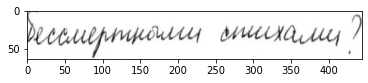

In [12]:
for imgs, text in train_dataloader:
    print(imgs.shape)
    plt.imshow(imgs[0][0], cmap = 'gray')
    print(text[0])
    break

In [ ]:
ep = 100

train_loss = []
train_acc_char = []
train_acc_str = []
train_cer = []

val_loss = []
val_acc_char = []
val_acc_str = []
val_cer = []

best_str_acc = 0

for epoch in range(ep):
    train_epoch_loss = []
    
    train_epoch_acc_char = []
    train_epoch_acc_str = []
    train_epoch_cer = []
    
    with tqdm(total = len(train_dataloader), ncols='100%') as bar_train:
        for i, (images, gt_text) in enumerate(train_dataloader):

            results = train_on_batch_rec(images, gt_text, net, ocr_loss, optimizer, device, batch_size, converter)
            loss, acc_char, acc_str, cer = results
            
            train_epoch_loss.append(loss)
            train_epoch_acc_char.append(acc_char)
            train_epoch_acc_str.append(acc_str)
            train_epoch_cer.append(cer)

            printed_data = f"Ep: {epoch}. Train loss: {np.mean(train_epoch_loss):.4f}.\
            Acc char: {np.mean(train_epoch_acc_char):.4f}.\
            Acc str: {np.mean(train_epoch_acc_str):.4f}.\
            CER: {np.mean(train_epoch_cer):.4f}."
            bar_train.set_description(printed_data)
            bar_train.update(1)
            
    train_loss.append(np.mean(train_epoch_loss))
    
    train_acc_char.append(np.mean(train_epoch_acc_char))
    train_acc_str.append(np.mean(train_epoch_acc_str))
    train_cer.append(np.mean(train_epoch_cer))
    
    
    val_epoch_loss = []
    
    val_epoch_acc_char = []
    val_epoch_acc_str = []
    val_epoch_cer = []
    
    with tqdm(total = len(val_dataloader), ncols='100%') as bar_val:
        for i, (images, gt_text) in enumerate(val_dataloader):

            results = val_on_batch_rec(images, gt_text, net, ocr_loss, device, batch_size, converter)
            loss, acc_char, acc_str, cer, decode_text, gt_text, raw_preds = results
            
            val_epoch_loss.append(loss)
            val_epoch_acc_char.append(acc_char)
            val_epoch_acc_str.append(acc_str)
            val_epoch_cer.append(cer)

            printed_data = f"Ep: {epoch}. Val loss: {np.mean(val_epoch_loss):.4f}.\
            Acc char: {np.mean(val_epoch_acc_char):.4f}.\
            Acc str: {np.mean(val_epoch_acc_str):.4f}.\
            CER: {np.mean(val_epoch_cer):.4f}."
            bar_val.set_description(printed_data)
            bar_val.update(1)
        
    val_loss.append(np.mean(val_epoch_loss))
    
    val_acc_char.append(np.mean(val_epoch_acc_char))
    val_acc_str.append(np.mean(val_epoch_acc_str))
    val_cer.append(np.mean(val_epoch_cer))
    
    print('Lr now:', optimizer.param_groups[0]['lr'])

    for raw_pred, pred, gt in zip(raw_preds, decode_text, gt_text):
        print('%-20s => %-20s, gt: %-20s' % (raw_pred, pred, gt)) 
    
    if epoch == 40:
        for g in optimizer_rnn.param_groups:
            g['lr'] = g['lr']*0.1
        for g in optimizer_conv.param_groups:
            g['lr'] = g['lr']*0.1
        print('Lr now:', optimizer_rnn.param_groups[0]['lr'])
        
    if epoch == 70:
        for g in optimizer_rnn.param_groups:
            g['lr'] = g['lr']*0.1
        for g in optimizer_conv.param_groups:
            g['lr'] = g['lr']*0.1
        print('Lr now:', optimizer_rnn.param_groups[0]['lr'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Lr now: 0.0001
А---------------------------------------------- => А                   , gt: сплю,               
А---------------------------------------------- => А                   , gt: АКТОБЕ              
А----------------------      ---------------  , => А  ,                , gt: Что делать нам с    
А------------------        -------------------- => А                   , gt: Южная Осетия        
А---------------------------------------------- => А                   , gt: И, докучных         



Lr now: 0.0001
А---------------------------------------------, => А,                  , gt: Абхазия             
К--------------------------------------------ая => Кая                 , gt: Сапипаев            
н-----       --------------------------р-----а- => н ра                , gt: не наглядясь        
А--    --------------------------------------ая => А ая                , gt: В накошенные        
---------------------------------------------а- => а                   , gt: изгнанья,           



Lr now: 0.0001
--------------------н------ее------------------ => не                  , gt: Огнем               
в------  с--в--оо----и-----------   с-----н---- => в свои сн           , gt: в свои сны          
по-------з----д-а----вв--оо-----т-------------- => поздавот            , gt: раздаваться         
зо------в------о--------дд----------т---о------ => зоводто             , gt: Заводской           
не--- ---к--а----------й------   -к-о-----н--я, => не кай коня,        , gt: Не жалей коня,      



Lr now: 0.0001
н--  ввс---то-----и---н--и--л---- -я----  --обй => н встоинил я обй    , gt: И вспомнил я тебя   
Ол--я---  -м---и---р--нно--йй---   -жо---н--зни => Оля мирной жонзни   , gt: Для мирной жизни    
-н-е-------  --л----нн----а------н--е-------  в => не лнане в          , gt: Она лежала в        
К----аа-------за-------х----с-----т----а------н => Казахстан           , gt: Казахстан           
Я-------------  --к----рр--е------п------к----о => Я крепко            , gt: Я крепко            



Lr now: 0.0001
З-ы------о-----я-------т------о---вв----с-----к => Зыоятовск           , gt: Зыряновск           
------------------л------------ыы------------е- => лые                 , gt: Злые                
с------п-------------------------н---------ю--, => спню,               , gt: сплю,               
нее----------  -в------м----------с------тт---е => не вмсте            , gt: Не вместе           
А-------Л--------Л-----------А------ТТ-----Ы--- => АЛЛАТЫ              , gt: АЛМАТЫ              



Lr now: 0.0001
св-о---е----й---------  ---до----р-о---г-о----й => своей дорогой       , gt: своей дорогой       
во-----з---в----р--аа-----тт------------с-----ь => возвратсь           , gt: возвратясь          
с  --рроо----зо--в-оо-йй-----   --зза-----р-е-й => с розовой зарей     , gt: с розовой зарей     
К---а-------рр--а---------тт------аа----------у => Каратау             , gt: Каратау             
Ко--сс---тта------н---а------л-----сс----а----л => Костаналсал         , gt: Костанайская        



Lr now: 0.0001
л------о------и-----------р-------у------ж----и => лоиружи             , gt: Мои руки            
Оо---т--ьь-----  -с-а-----м--------  -тт---о-чь => Ооть сам точь       , gt: Хоть сам того       
Т--------д--е-------  --л-------а-------н-----к => Тде ланк            , gt: Где танк            
Р-----------------с------сс---------и---------я => Рссия               , gt: Россия              
М---------с-----а-------к---о------в---сс----к- => Мсаковск            , gt: Лисаковск           



Lr now: 0.0001
звоо---и---к---и---хх------ сс--т---р----у--йй. => звоиких струй.      , gt: звонких струй.      
А-----------к--------тт------о-------бб-----ее- => Актобе              , gt: Актобе              
Ка----р--а----г-а-----н----д--и---н-сс--ккаа--я => Карагандинская      , gt: Карагандинская      
Д-а----л----к--о-------   с-----  --м---о---рря => Далко с моря        , gt: Далеко с моря       
М--------о------л------д--а-----в------и-----я- => Молдавия            , gt: Молдавия            



Lr now: 0.0001
с--к-----о-------р----ю---------   --л-----и--, => скорю ли,           , gt: скоро ли,           
Чт---  --д-ее--лла----тьь---  -н-а-----л----- с => Чт делать нал с     , gt: Что делать нам с    
в-----п--о-----т------ь------м------аа-------х. => впотьмах.           , gt: впотьмах.           
Я------------------  --З-------р-----у-----ии-х => Я Зруих             , gt: яд другим           
Г------------о----------лл----------оо------с-- => Голос               , gt: Голос               



Lr now: 0.0001
А--кк---т------ю---бб---ии---нн-сс---к--а-----я => Актюбинская         , gt: Актюбинская         
Д-рее--мм----я------  с--мм---о-----л--к---н-ул => Дремя смолкнул      , gt: Дремля смолкнул     
нее-------  -вв----с--е-----гг-------д--о-----, => не всегдо,          , gt: не всегда,          
И- --м----а----я---к---ии----  с--к--вв--оо--зь => И маяки сквозь      , gt: И маяки сквозь      
К---у---л-----ь------сс-----а-------р-----ы---- => Кульсары            , gt: Кульсары            



Lr now: 0.0001
----д------в-------а-----рр-----------а-------, => двара,              , gt: двора,              
Б-----е-----с------тт------------о------б----ее => Бестобе             , gt: Бестобе             
З---а----ч-----а----------аа-----н-----а-----к- => Зачаанак            , gt: Зачаганск           
П--ее---т----р-о----п-аа---вв----л-о---вв--сс-к => Петропавловск       , gt: Петропавловск       
К-а-------н-------д--ы--и------г---а-------и--- => Кандыигаи           , gt: Кандыагаш           



Lr now: 0.0001
С------------------------------я---------кк---- => Сяк                 , gt: Саяк                
К-------ии----р------гг-----и-------з----ии---я => Киргизия            , gt: Киргизия            
ка--к-------   --м----о----ллоо----ддо-с---тт-ь => как молодость       , gt: как молодость       
Сле---п--ыи---м-------   вв-о---л--ч--а----то-м => Слепыим волчатом    , gt: Слепым волчатам     
З---р---о--------ш-------ь-----------а--------у => Зрошьау             , gt: Хромтау             



Lr now: 0.0001
З--а------------а------гг---а-------н--е------к => Зааганек            , gt: Зачаганск           
Гдде-----  -в--ыы----л----   -п--о------ж--а--р => Где выл пожар       , gt: Где выл пожар       
Р---------о-------г---------------о-------с---- => Рогос               , gt: Голос               
перре---ш---е---л--  -н-а----  -ш---е---н-о---т => перешел на шенот    , gt: перешел на шепот    
п---------------------------------------------- => п                   , gt: п.                  



Lr now: 0.0001
А--л-----м----а-----т---------и---сс----к--аа-я => Алматиская          , gt: Алматинская         
Ю---ж-----н--а----я-----  -д---с-е----т-------и => Южная дсети         , gt: Южная Осетия        
Что--  --м-ее--т-ее--  -сс--к-о--рр--м----ии-ле => Что мете скормиле   , gt: что меня вскормила  
от--------  -с---тт---рр--а-----д-аа----нн--ь-я => от страданья        , gt: от страданья        
А-л----м--я-----т------и----н---с----К----а---я => АлмятинсКая         , gt: Алматинская         



Lr now: 0.0001
че-----мм-----------  сс---о------н-------!!.-. => чем сон!..          , gt: чем сон!..          
Ш-----а------х-------т--------и------н---сс---к => Шахтинск            , gt: Шах тинск           
Ю-ж--ноо---Кааза----хх----сс--тт-а---н-сс-к-а-я => Южно-Казахстанская  , gt: Южно-Казахстанская  
Е----------с----------и---------------лл------ь => Есиль               , gt: Есиль               
в------------ыы---------------с---------------- => выс                 , gt: выси                



Lr now: 0.0001
Ж----А-----М---Б----Ы-----Л---Ь----С----К---А-я => ЖАМБЫЛЬСКАя         , gt: ЖАМБЫЛЬСКАЯ         
К-----е--------и----------т-------а----------уу => Кеитау              , gt: Кентау              
К--а--------з--а---------х-----с-----Т--а-----н => КазахсТан           , gt: Казахстан           
зв-о----и---к---и----х---------  сс---ттрр--ууй => звоиких струй       , gt: звонких струй       
Б---ее------л--оо-----р-------у-с--сс-----и---я => Белоруссия          , gt: Белоруссия          



Lr now: 0.0001
Ещ-щее--  -нне---  -п-о---х-в-ии-в---иш----е-ся => Ещще не похвивишеся , gt: Еще не появившиеся  
не   -зза--б---е---л-и---   --м---ии--нн--о--й, => не забели миной,    , gt: не забили глиной,   
С--------р----ы-------чи------г-----а-------и-- => Срычигаи            , gt: Сарыагаш            
К---о--сс----т---а-----н--а----й-------к-а----я => Костанайкая         , gt: Костанайская        
А--к-----м----о----л----ии---н---сс---к--аа---я => Акмолинская         , gt: Акмолинская         



Lr now: 0.0001
У------к-------рр----а---------и-------н-----а- => Украина             , gt: Украина             
О-!------  -ЗЗЗ--а-----чч-ее----м---------- -яя => О! Зачем я          , gt: О! Зачем я          
И------   с----д--н----у-----  --м------шш-ш--ь => И сдну мшшь         , gt: И одну лишь         
Во---т----и--в------  с---тт-----рр-о--г---и--х => Вотив строгих       , gt: ротив строгих       
Ст-о-гг----   пп-рр-ии---н--и----м---а---е---тт => Стог принимает      , gt: Стог принимает      



Lr now: 0.0001
отл-------  сс---тт---рр-а-----д-а-----н-ь---я, => отл страданья,      , gt: от страданья,       
кля----тт--в-оо--йй----  -о--бб-ее----щща----я, => клятвой обещая,     , gt: клятвой обещал;     
К------------р------аа-----с-------ии---------- => Краси               , gt: Украина             
Ш---------ы---------м--------к--ее----ни----тт- => Шымкенит            , gt: Шымкент             
В-и----д----   -п--о--с----т--о---яя---л--о--го => Вид постоялого      , gt: Вид постоялого      



Lr now: 0.0001
в-----лл-----------ю------б------лл----е------н => влюблен             , gt: влюблен             
с------нн-----------л----------------ю--------, => снлю,               , gt: сплю,               
На--м-------  -эттто---   ннее---   --ууз-наать => Нам это не узнать   , gt: Нам это не узнать   
Ка----р-а---гг-а----нн---дд--и---н--с---к--а--я => Карагандинская      , gt: Карагандинская      
Д----р----у---г-----------  --дд-рр-----у--гг-у => Друг другу          , gt: Друг другу          



Lr now: 0.0001
А---------тт---------ыы------р-------аа-------у => Атырау              , gt: Атырау              
Заа------ч----а------г----а--------н----с-----к => Зачаганск           , gt: Зачаганск           
И--------------  -с-ее-----р-------дд-------ц-е => И сердце            , gt: И сердце            
ле-гг--кк--и--ее-----  --л-е----тт-----я----л-. => легкие летял.       , gt: легкие летят.       
О------гг-------н-----е------------мл---------- => Огнемл              , gt: Огнем               



Lr now: 0.0001
Ко-г--д-а-------  -ы--в--о-ее-----  -м---ии--цо => Когда ывое мицо     , gt: Когда твое лицо     
П------аа-----вв-----лл-----о-------д--а------р => Павлодар            , gt: Павлодар            
И--  --жж---ии---зз-н--ь---г-о--б--о---лее--е-, => И жизньгоболее,     , gt: И жизньпоболее,     
И  бб--у--д---уу-тт-----  -м---с---т----ии--тть => И будут мстить      , gt: И будут мстить      
О--п---------тт--ьь-------   --п--о-------нн--ы => Опть поны           , gt: Опять полны         



Lr now: 0.0001
лон--ы--хх-----   -п-а--кк-о----е-----н--ии--и, => лоных пакоении,     , gt: юных поколении,     
С--тт---ее----п----н---оо---гг-о-----р-------кк => Степногорк          , gt: Степногорск         
М-----о------и---------  --рр------у---к-----ии => Мои руки            , gt: Мои руки            
М------о-----л------д--а-------вв-----ии-----яя => Молдавия            , gt: Молдавия            
Ч-тт--о---   --д-о--б--рр-о----д-е----т--е---ль => Что добродетель     , gt: Что добродетель     



Lr now: 0.0001
С------ки------------------х------------------- => Ских                , gt: Скучно              
Дрре---мм----л-яя---  с---м---о---л--к---н--уул => Дремля смолкнул     , gt: Дремля смолкнул     
несс--яя---цц---  -мм--и---м--о--е---зз---ж-лй, => несяц мимоезжлй,    , gt: месяц мимоезжий,    
А----т----ыы-----рр-а------у--с----кк---а-----я => Атырауская          , gt: Атырауская          
---------дд------ее--------н-----------------ьь => день                , gt: день                



Lr now: 0.0001
с----тт------------ы-----------дд-----аа------- => стыда               , gt: стыда               
в-а-----н---ии---г-е----л----------   с--в--о-й => ванигел свой        , gt: выжигал свой        
А---тт---ы------рр--аа-------у-сс---к---а-----я => Атырауская          , gt: Атырауская          
А-л----м------а-----т---и-----н--сс----к--а---я => Алматинская         , gt: Алматинская         
И- -че----л--о--вв--е--кк-----   -поо---шш--ё-л => И человек пошёл     , gt: И человек пошёл     



Lr now: 0.0001
А--лл----м----а------т--ии---н--сс---к--а-----я => Алматинская         , gt: Алматинская         
А--------С---------т-----а---------Н---------А- => АСтаНА              , gt: АСТАНА              
ддд-----жж---------и------гг-----и------т------ => джигит              , gt: джигит              
На--- --дд-рее-вв--нн-е---й----  сс---т--е---не => На древней стене    , gt: На древней стене    
А-------------------------ыыы---------а-------ь => Аыаь                , gt: Арысь               



Lr now: 0.0001
Сн--у---ю----т------  -п--уу-нн----ццо---вв-ыые => Снуют пунцовые      , gt: Снуют пунцовые      
А------т---------б-----а------с-----а---------р => Атбасар             , gt: Атбасар             
Но   воо-с-чаа---т---  -нее---  -п--рро--н--ут, => Но восчат не пронут,, gt: Но волчат не тронул,
Запа--дд-н-о---Кааза----хх---сс-тт-а--нн--каа-я => Западно-Казахстанкая, gt: Западно-Казахстанская
Р-е-----вв---е-----л---аа--------  --о-------т- => Ревела от           , gt: Ревела от           



Lr now: 0.0001
Д--л------  --м--ии--р---но--й----  -жж-и---зни => Дл мирной жизни     , gt: Для мирной жизни    
П--ее------рр-оо----п--а----в-----л-оо--в--с--к => Перопавловск        , gt: Петропавловск       
Б--е-----л---о-----р-------у-сс--сс-----ии----я => Белоруссия          , gt: Белоруссия          
Ю---ЖЖ---НН-А----Я------  -О---С-еЕ-----Т--И--Я => ЮЖНАЯ ОСеЕТИЯ       , gt: ЮЖНАЯ ОСЕТИЯ        
б--е------л----о----рр-----у-сс--сс------ии---я => белоруссия          , gt: Белоруссия          
